In [11]:
#!/usr/bin/env python
# coding: utf-8

import os
import numpy as np # linear algebra
from PIL import Image

import random

from tqdm import tqdm

import torch
from torch import nn
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
import torchvision.transforms as transforms
from utils.Loss import *
import cv2
from models.ResUnet import *


class CenterCrop(object):
    def __init__(self,arg):
        self.transform = transforms.CenterCrop(arg)
    def __call__(self, sample):
        img, label = sample
        return self.transform(img),self.transform(label)

class Resize(object):
    def __init__(self,arg):
        self.transform_img = transforms.Resize(arg,Image.BILINEAR)
        self.transform_label = transforms.Resize(arg,Image.NEAREST)

    def __call__(self, sample):
        img, label = sample
        return self.transform_img(img),self.transform_label(label)

class Normalize(object):
    def __init__(self,mean,std):
        self.transform = transforms.Normalize(mean, std)
    def __call__(self, sample):
        img, label = sample
        return self.transform(img),label

class ToTensor(object):
    def __init__(self):
        pass
    def __call__(self, sample):
        img, label = sample
        label = np.array(label)/255
        img = np.array(img)
        img = (img-img.min())/(img.max()-img.min())
        return torch.from_numpy(img.transpose((2, 0, 1))).float(),torch.from_numpy(label.copy()).long()

class RandomRescale(object):
    def __init__(self,min_ratio=0.5,max_ratio=1.0):
        self.min_ratio = min_ratio
        self.max_ratio = max_ratio
    def __call__(self, sample):
        img, label = sample
        width, height = img.size
        ratio = random.uniform(self.min_ratio,self.max_ratio)
        new_width, new_height = int(ratio*width), int(ratio*height)
        return img.resize((new_width,new_height)), label.resize((new_width,new_height))

class RandomFlip(object):
    def __init__(self,p=0.5):
        self.p = p

    def __call__(self, sample):
        img, label = sample
        if random.uniform(0,1)>self.p:
            return transforms.functional.hflip(img),transforms.functional.hflip(label)
        else:
            return img, label

class RandomColor(object):
    def __init__(self,brightness=0.3,contrast=0.3,saturation=0,hue=0):
        self.transform = transforms.ColorJitter(brightness,contrast,saturation,hue)
    def __call__(self, sample):
        img, label = sample
        return self.transform(img),label

class RandomRotation(object):
    def __init__(self, degree=[-3,3]):
        self.degree = degree

    def __call__(self, sample):
        img, label = sample

        angle = transforms.RandomRotation.get_params(self.degree)

        #img = transforms.functional.rotate(img, angle,resample = Image.BILINEAR)
        img = transforms.functional.rotate(img, angle)
        label = transforms.functional.rotate(label, angle)
        return img, label

class RandomCrop(object):
    def __init__(self,output_size):
        self.output_size = output_size
    def __call__(self, sample):
        img, label = sample

        i, j, h, w = transforms.RandomCrop.get_params(
            img, output_size=self.output_size)

        img = transforms.functional.crop(img, i, j, h, w)
        label = transforms.functional.crop(label, i, j, h, w)
        return img,label

    
class CovidCTDataset(Dataset):
    """Covid XRay dataset."""

    def __init__(self, txt, transforms):
        self.IMAGE_LIB = r'D:\data\Finding_and_Measuring_Lungs_in_CT_Data\2d_images'
        self.MASK_LIB = r'D:\data\Finding_and_Measuring_Lungs_in_CT_Data\2d_masks'
    
        self.images = np.loadtxt(txt,dtype=str)
        
        self.transform = transforms

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image_name = self.images[idx]
        #print(os.path.join(self.IMAGE_LIB + "\\" + image_name))
        img = cv2.imread(os.path.join(self.IMAGE_LIB + "\\" + image_name), cv2.IMREAD_UNCHANGED).astype("int16").astype('float32')
        img = (img - np.min(img)) / (np.max(img) - np.min(img))
        img = Image.fromarray(np.uint8(img*255)).convert('RGB')
        label = Image.open(os.path.join(self.MASK_LIB + "\\" + image_name))
        
        if self.transform:
            img,label = self.transform((img,label))
        sample = {'img': img,
                  'label': label}
        return sample
    
def train(model,train_loader,optimizer,LOSS_FUNC,EPOCH,PRINT_INTERVAL, epoch, device):
    losses = []
    for i, batch in enumerate(tqdm(train_loader)):
        img, label = batch['img'].to(device), batch['label'].to(device)
        output = model(img)
        optimizer.zero_grad()

        loss = LOSS_FUNC(output, label)

        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        if (i + 1) % PRINT_INTERVAL == 0:
            tqdm.write('Epoch [%d/%d], Iter [%d/%d], Loss: %.4f'
                       % (epoch + 1, EPOCH, i + 1, len(train_loader), loss.item()))
    return np.mean(losses)

def eval(model,val_loader,LOSS_FUNC, device):
    losses = []
    for i, batch in enumerate(val_loader):
        img, label = batch['img'].to(device), batch['label'].to(device)
        output = model(img)
        loss = LOSS_FUNC(output, label)
        losses.append(loss.item())
    return np.mean(losses)


transform = transforms.Compose([
        RandomRescale(0.8,1.2),
        RandomCrop((224,224)),
        RandomColor(),
        RandomFlip(),
        RandomRotation(),
        ToTensor(),
        Normalize(mean=[0.5, 0.5, 0.5],
                  std=[0.5, 0.5, 0.5])
    ])
test_transform = transforms.Compose([
        Resize((224,224)),
        ToTensor(),
        Normalize(mean=[0.5, 0.5, 0.5],
                  std=[0.5, 0.5, 0.5])
    ])
train_dst = CovidCTDataset(txt='train.txt',
                           transforms=transform)
valid_dst = CovidCTDataset(txt='test.txt',
                           transforms=test_transform)
batch_size = 8
print("Train set {}\nValidation set {}\n".format(len(train_dst),len(valid_dst)))

train_loader = DataLoader(train_dst,batch_size=batch_size,shuffle=True)
valid_loader = DataLoader(valid_dst,batch_size=batch_size,shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResUNet().to(device)
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = nn.DataParallel(model).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
lr_sheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
LOSS_FUNC = DiceCELoss().to(device)
PRINT_INTERVAL = 5
EPOCH= 100

val_loss_epoch = []
for epoch in range(EPOCH):

    model.train()
    train_loss = train(model, train_loader, optimizer, LOSS_FUNC, EPOCH, PRINT_INTERVAL, epoch, device)
    val_loss = eval(model, valid_loader, LOSS_FUNC, device)
    val_loss_epoch.append(val_loss)
    lr_sheduler.step()
    tqdm.write('Epoch [%d/%d], Aveage Train Loss: %.4f, Aveage Valiation Loss: %.4f'
               % (epoch + 1, EPOCH, train_loss, val_loss))

    if val_loss == np.min(val_loss_epoch):
        print('Model saved')
        state = {
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
        torch.save(state, 'best.pth.tar')

Train set 200
Validation set 67



 24%|███████████████████▉                                                               | 6/25 [00:01<00:03,  5.20it/s]

Epoch [1/100], Iter [5/25], Loss: 1.2791


 44%|████████████████████████████████████                                              | 11/25 [00:02<00:02,  5.46it/s]

Epoch [1/100], Iter [10/25], Loss: 1.0772


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:03<00:01,  5.58it/s]

Epoch [1/100], Iter [15/25], Loss: 1.2368


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  5.61it/s]

Epoch [1/100], Iter [20/25], Loss: 1.1446


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  5.33it/s]


Epoch [1/100], Iter [25/25], Loss: 1.0134
Epoch [1/100], Aveage Train Loss: 1.1887, Aveage Valiation Loss: 1.2019
Model saved


 24%|███████████████████▉                                                               | 6/25 [00:01<00:03,  5.52it/s]

Epoch [2/100], Iter [5/25], Loss: 1.1096


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  5.54it/s]

Epoch [2/100], Iter [10/25], Loss: 0.9323


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  5.55it/s]

Epoch [2/100], Iter [15/25], Loss: 0.8714


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  5.66it/s]

Epoch [2/100], Iter [20/25], Loss: 0.8772


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  5.58it/s]


Epoch [2/100], Iter [25/25], Loss: 0.7872
Epoch [2/100], Aveage Train Loss: 0.9710, Aveage Valiation Loss: 1.0317
Model saved


 24%|███████████████████▉                                                               | 6/25 [00:01<00:03,  5.63it/s]

Epoch [3/100], Iter [5/25], Loss: 0.9782


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  5.64it/s]

Epoch [3/100], Iter [10/25], Loss: 0.7478


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  5.64it/s]

Epoch [3/100], Iter [15/25], Loss: 0.8510


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  5.70it/s]

Epoch [3/100], Iter [20/25], Loss: 0.9594


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  5.66it/s]


Epoch [3/100], Iter [25/25], Loss: 0.7877
Epoch [3/100], Aveage Train Loss: 0.9026, Aveage Valiation Loss: 0.9918
Model saved


 24%|███████████████████▉                                                               | 6/25 [00:01<00:03,  5.69it/s]

Epoch [4/100], Iter [5/25], Loss: 0.7668


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  5.57it/s]

Epoch [4/100], Iter [10/25], Loss: 0.8153


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  5.51it/s]

Epoch [4/100], Iter [15/25], Loss: 0.7562


 80%|█████████████████████████████████████████████████████████████████▌                | 20/25 [00:03<00:00,  5.57it/s]

Epoch [4/100], Iter [20/25], Loss: 0.7749


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  5.60it/s]


Epoch [4/100], Iter [25/25], Loss: 0.8565
Epoch [4/100], Aveage Train Loss: 0.8160, Aveage Valiation Loss: 0.9483
Model saved


KeyboardInterrupt: 

In [13]:
for val_data in valid_loader:
    val_images, val_labels = val_data["img"].to(device), val_data["label"].to(device)
    break
val_images[:1].shape

torch.Size([1, 3, 224, 224])

In [3]:
model.eval()
for val_data in valid_loader:
    val_images, val_labels = val_data["img"].to(device), val_data["label"].to(device)
    dummy_input = val_images[:1]
    torch.onnx.export(model, dummy_input, "rsegv1.onnx", verbose=True,
                      input_names=['input'],
                      output_names=['output'], keep_initializers_as_inputs=True)
    break

C:\anaconda3\Lib\site-packages\torch\onnx\utils.py:689: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\jit\passes\onnx\constant_fold.cpp:181.)
  _C._jit_pass_onnx_graph_shape_type_inference(
C:\anaconda3\Lib\site-packages\torch\onnx\utils.py:1186: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\jit\passes\onnx\constant_fold.cpp:181.)
  _C._jit_pass_onnx_graph_shape_type_inference(


================ Diagnostic Run torch.onnx.export version 2.0.1 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [4]:
import onnxruntime as ort
import psutil
sess_options = ort.SessionOptions()
sess_options.execution_mode = ort.ExecutionMode.ORT_PARALLEL
sess_options.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL
sess_options.intra_op_num_threads = psutil.cpu_count(logical=True)
modelonnx = ort.InferenceSession("rsegv1.onnx", sess_options,
                                 ["CPUExecutionProvider", "CUDAExecutionProvider"])

IMAGE_LIB = r"D:\data\Finding_and_Measuring_Lungs_in_CT_Data\2d_images"
image_name = "ID_0000_Z_0142.tif"
img = cv2.imread(os.path.join(IMAGE_LIB + "\\" + image_name), cv2.IMREAD_UNCHANGED).astype("int16").astype('float32')
img = (img - np.min(img)) / (np.max(img) - np.min(img))
img = Image.fromarray(np.uint8(img*255)).convert('RGB')

test_transform = transforms.Compose([
        Resize((224,224)),
        ToTensor(),
        Normalize(mean=[0.5, 0.5, 0.5],
                  std=[0.5, 0.5, 0.5])
    ])
img_value = test_transform((img,img))[0]
print(img_value.shape)
val_outputs = modelonnx.run(None, {"input": [img_value.detach().numpy()]})
print(val_outputs[0].shape)

torch.Size([3, 224, 224])
(1, 2, 224, 224)


(1, 2, 224, 224)
torch.Size([1, 3, 224, 224])
(3, 224, 224)


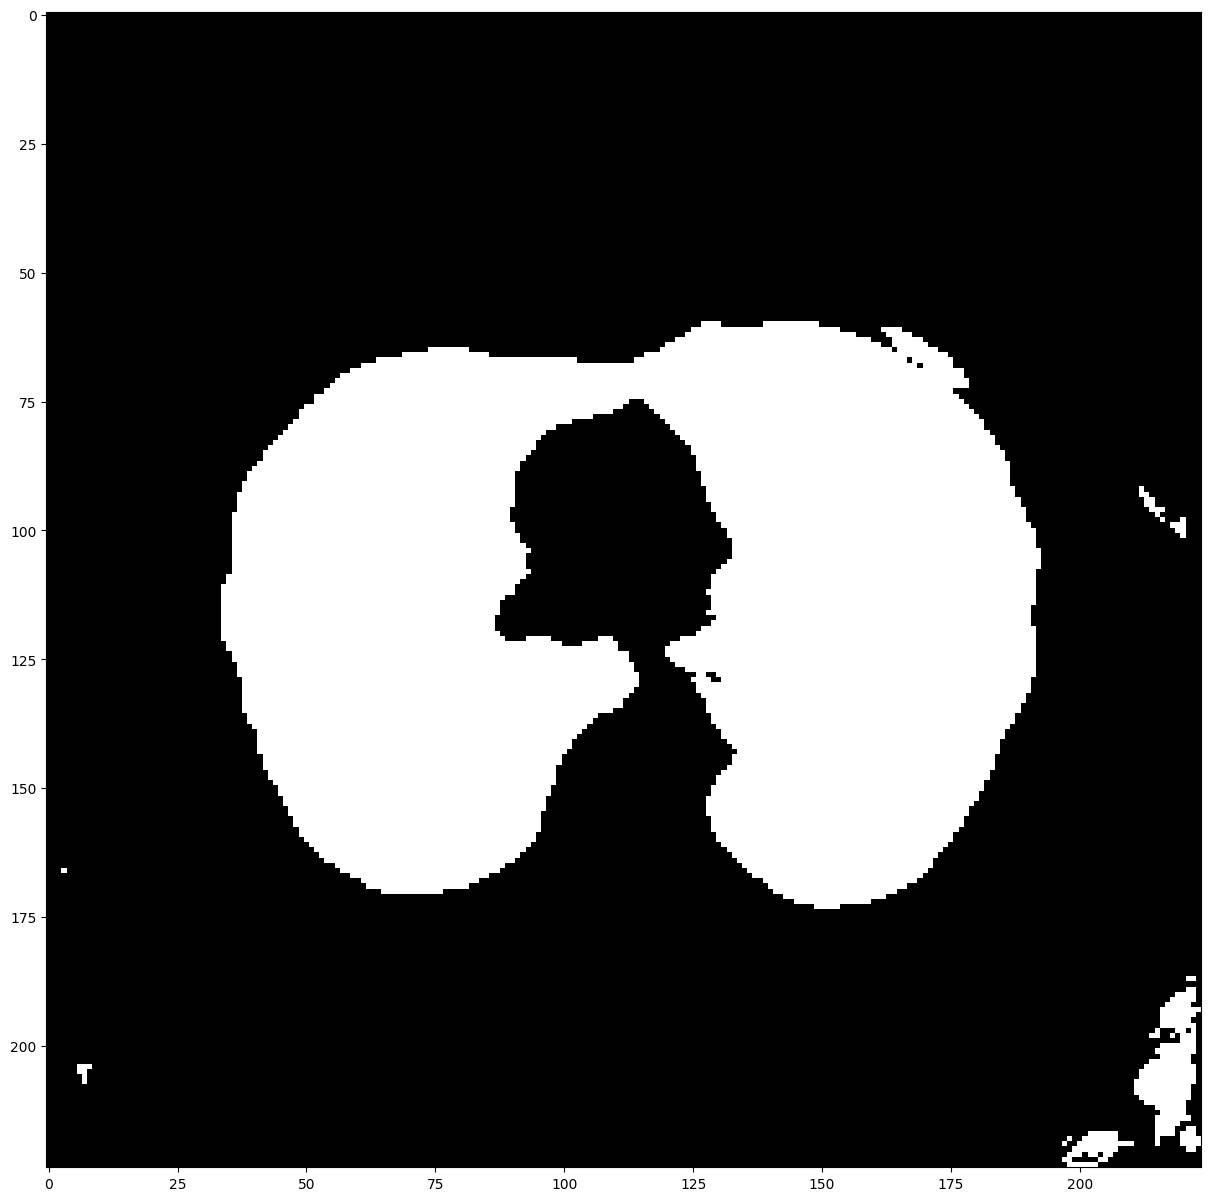

In [5]:
import torchvision
import matplotlib.pyplot as plt

def imshow_pred(img):
    npimg = img.numpy() * 255
    print(npimg.shape)
    plt.figure(figsize=(15,15))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
print(val_outputs[0].shape)
_, preds = torch.max(torch.tensor(val_outputs[0]), 1)
preds = torch.cat([preds.unsqueeze(1),preds.unsqueeze(1),preds.unsqueeze(1)],dim=1)
print(preds.shape)
imshow_pred(torchvision.utils.make_grid(preds.cpu(),nrow=4))

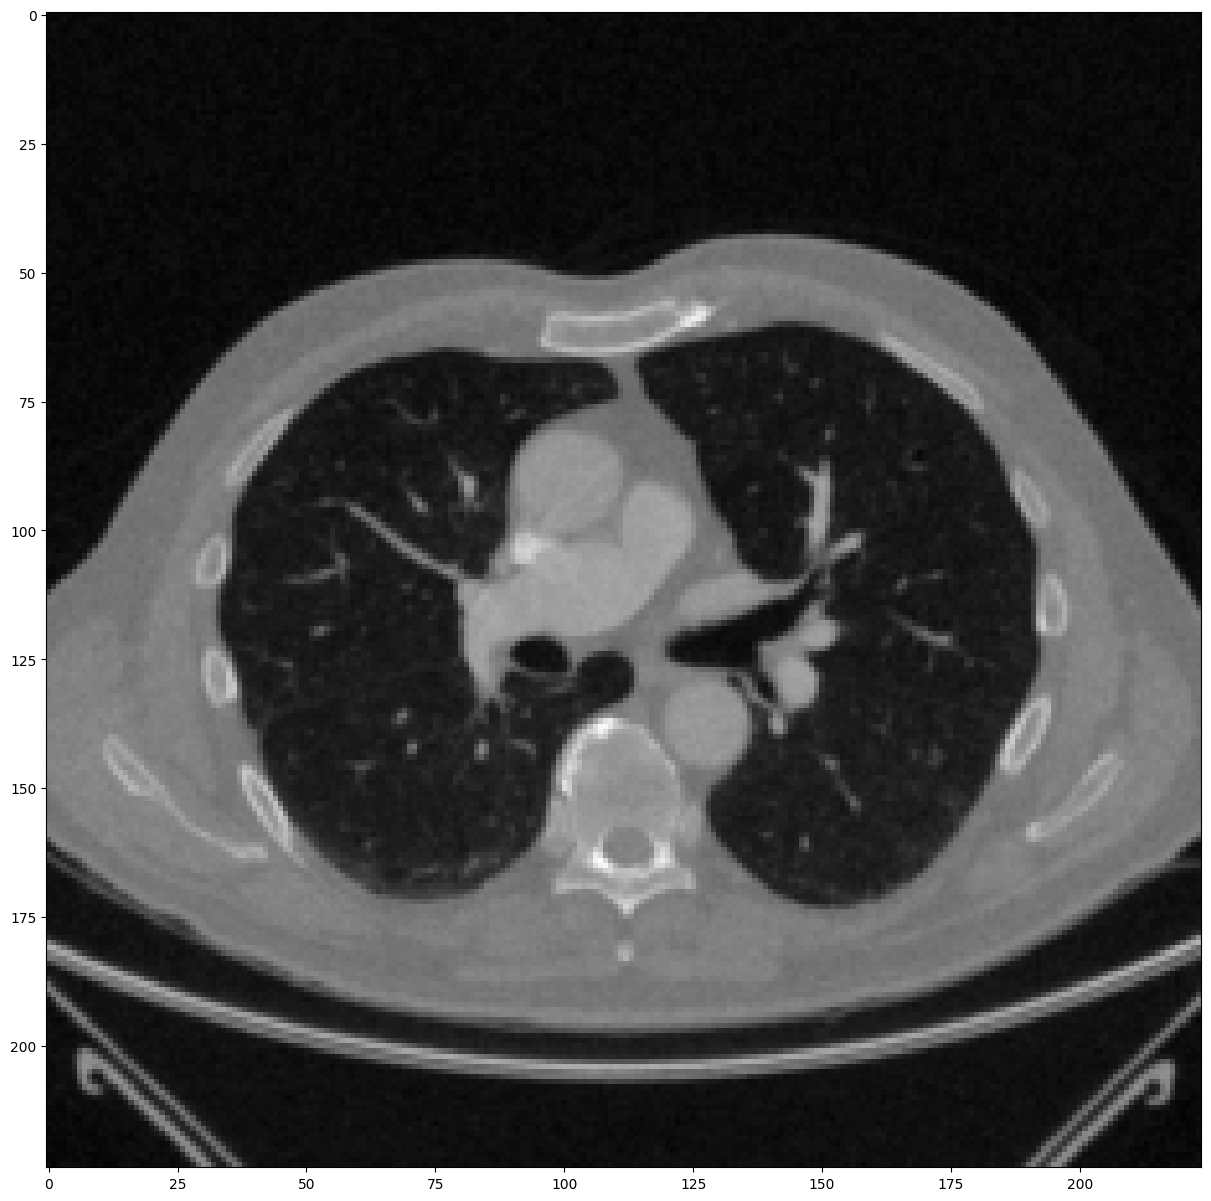

In [6]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(15,15))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
imshow(torchvision.utils.make_grid(img_value,nrow=4))

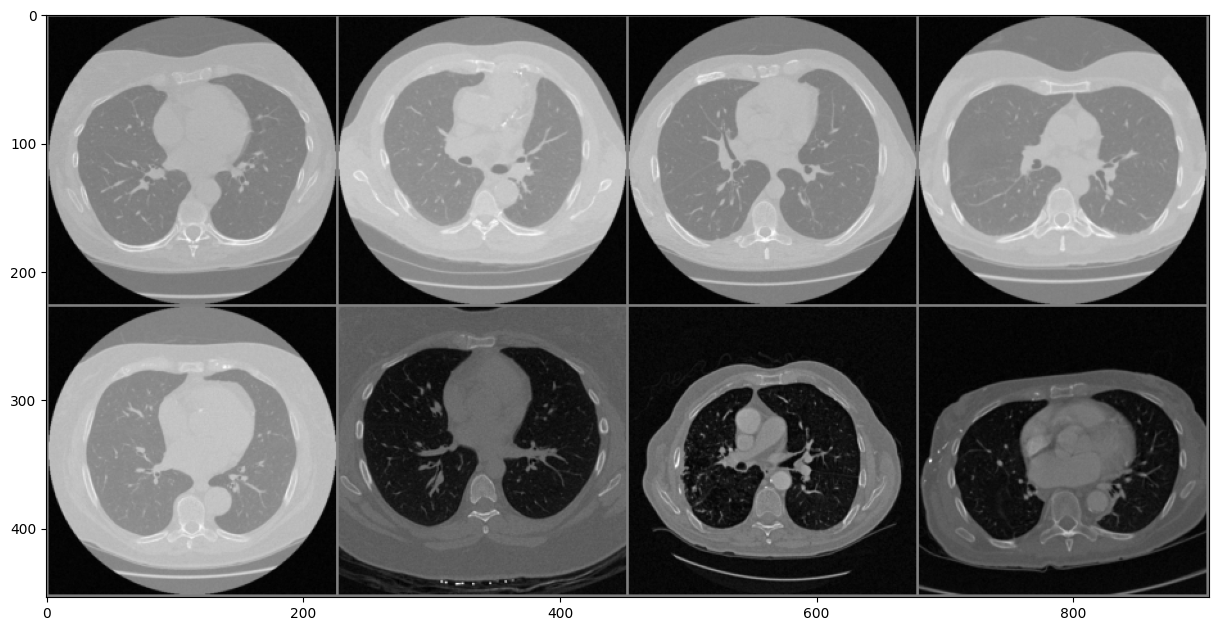

torch.Size([8, 3, 224, 224])
(3, 454, 906)


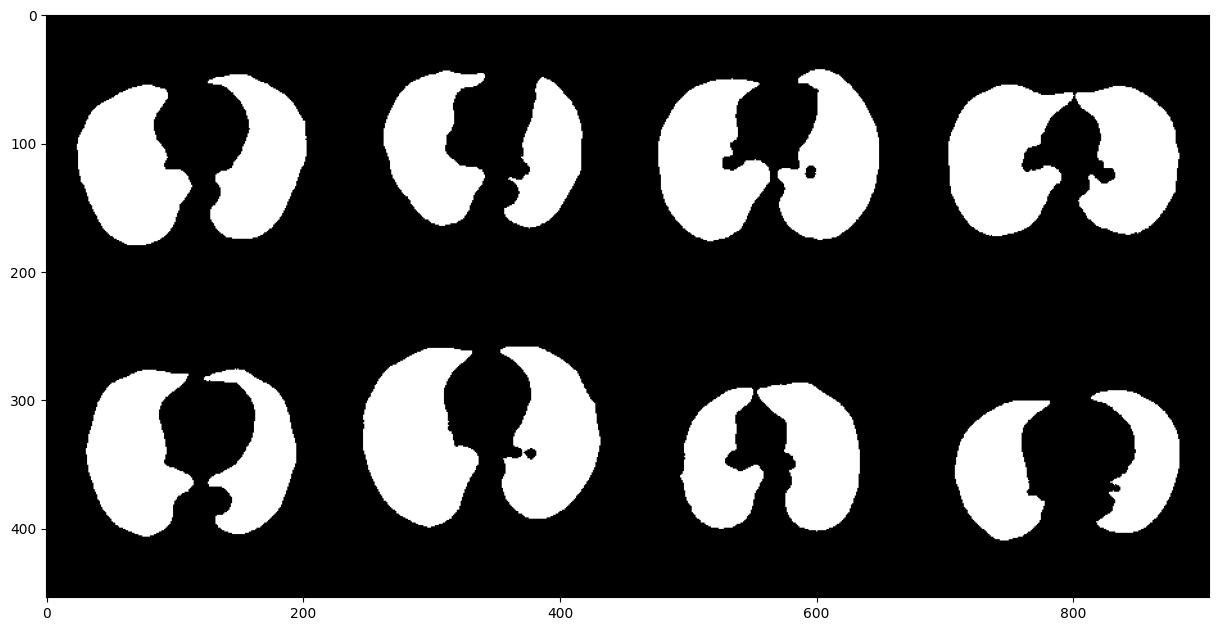

output, torch.Size([8, 2, 224, 224])
torch.Size([8, 3, 224, 224])
(3, 454, 906)


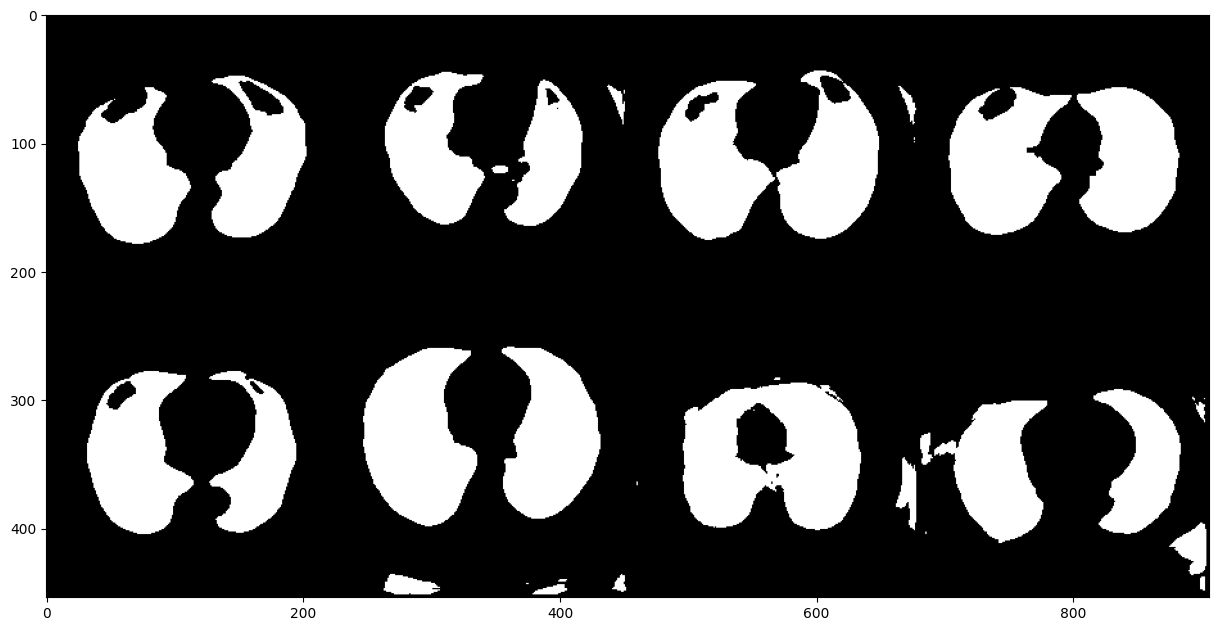

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
%matplotlib inline 
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(15,15))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def imshow_pred(img):
    npimg = img.numpy() * 255
    print(npimg.shape)
    plt.figure(figsize=(15,15))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
for val_data in valid_loader:
    images, labels = val_data["img"], val_data["label"]
    break
#batch = dataiter.next()
#images, labels = batch['img'], batch['label']
# show images
imshow(torchvision.utils.make_grid(images,nrow=4))
labels_image = torch.cat([labels.unsqueeze(1),labels.unsqueeze(1),labels.unsqueeze(1)],dim=1)
print(labels_image.shape)
imshow_pred(torchvision.utils.make_grid(labels_image,nrow=4))
# print labels
output = model(images.to(device))
print("output,",output.shape)
_, preds = torch.max(output, 1)
preds = torch.cat([preds.unsqueeze(1),preds.unsqueeze(1),preds.unsqueeze(1)],dim=1)
print(preds.shape)
imshow_pred(torchvision.utils.make_grid(preds.cpu(),nrow=4))

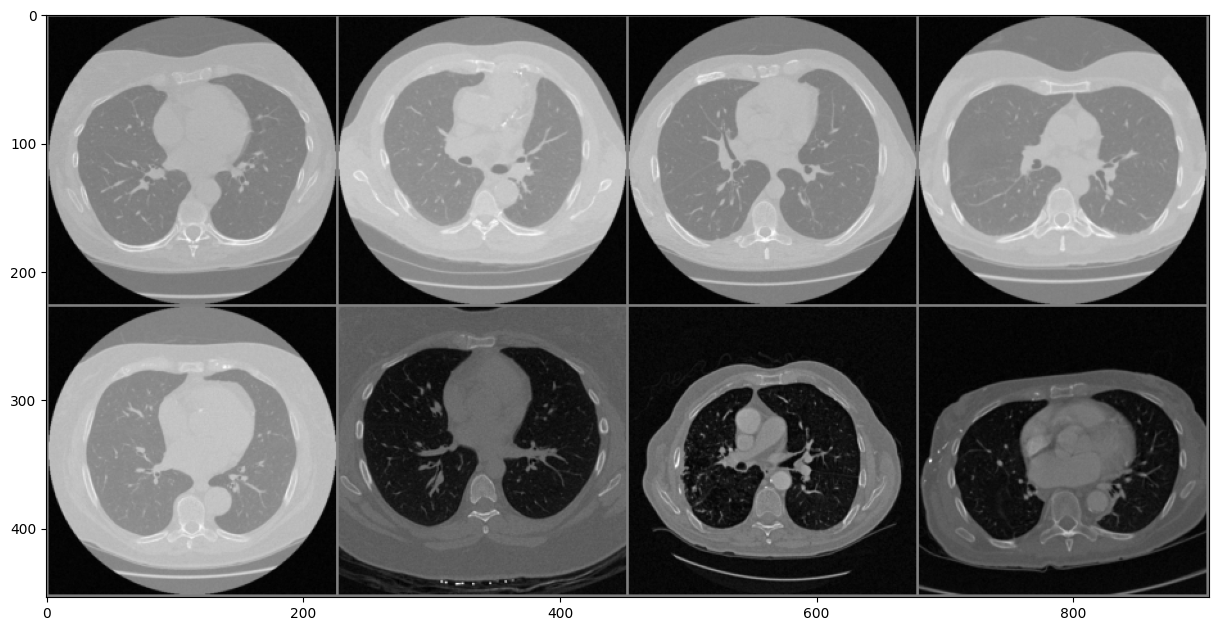

torch.Size([8, 3, 224, 224])
(3, 454, 906)


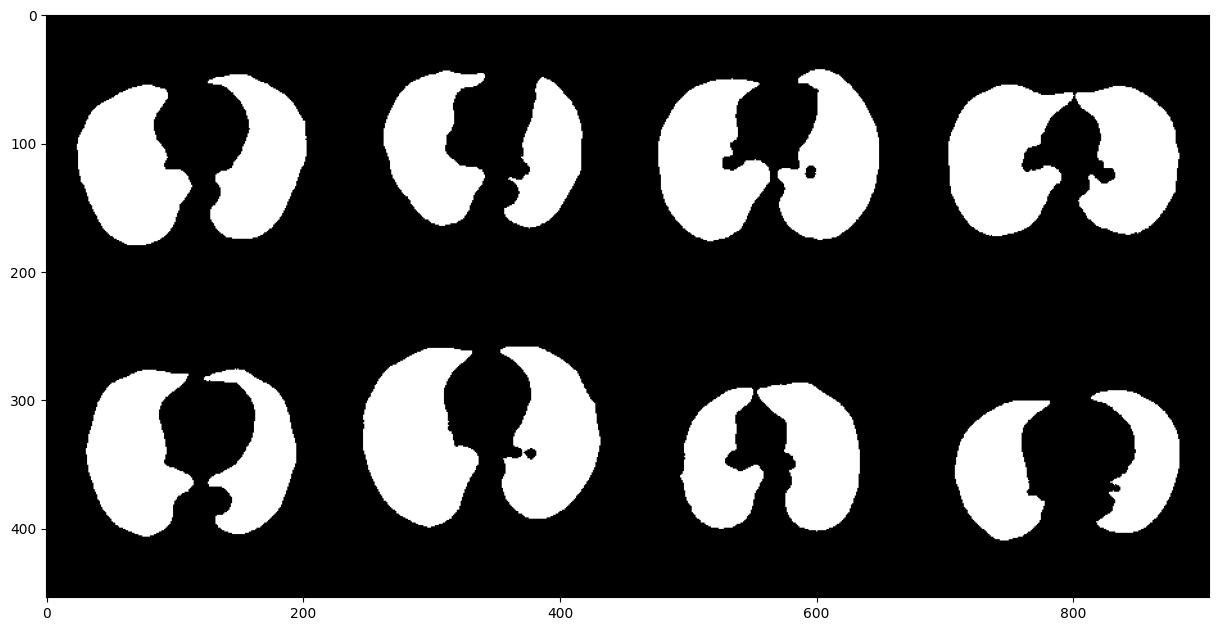

torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
(3, 454, 906)


C:\Users\A\AppData\Local\Temp\ipykernel_16336\2170489300.py:55: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:248.)
  output = torch.tensor(pred)


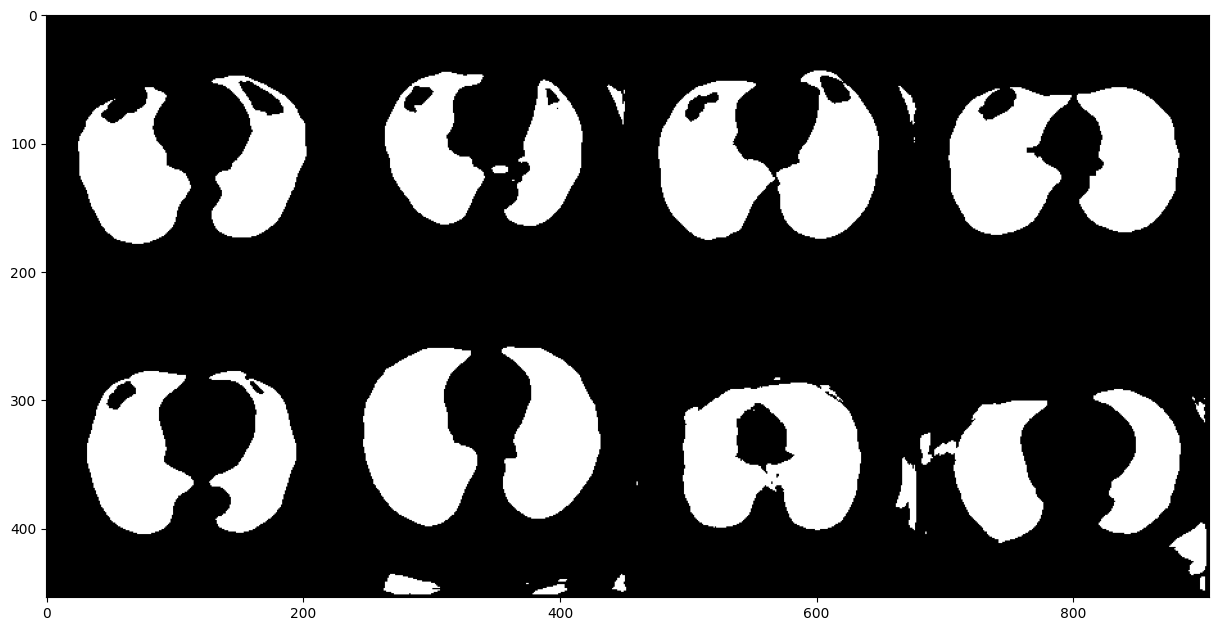

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import onnxruntime as ort
import psutil
%matplotlib inline 

# functions to show an image

def onnxpred(img):

    sess_options = ort.SessionOptions()
    sess_options.execution_mode = ort.ExecutionMode.ORT_PARALLEL
    sess_options.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL
    sess_options.intra_op_num_threads = psutil.cpu_count(logical=True)
    modelonnx = ort.InferenceSession("rsegv1.onnx", sess_options,
                                     ["CPUExecutionProvider", "CUDAExecutionProvider"])

    val_outputs = modelonnx.run(None, {"input": [img.detach().numpy()]})
    return val_outputs

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(15,15))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def imshow_pred(img):
    npimg = img.numpy() * 255
    print(npimg.shape)
    plt.figure(figsize=(15,15))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
#for val_data in valid_loader:
#    images, labels = val_data["img"], val_data["label"]
#    break
#batch = dataiter.next()
#images, labels = batch['img'], batch['label']
# show images
imshow(torchvision.utils.make_grid(images,nrow=4))
labels_image = torch.cat([labels.unsqueeze(1),labels.unsqueeze(1),labels.unsqueeze(1)],dim=1)
print(labels_image.shape)
imshow_pred(torchvision.utils.make_grid(labels_image,nrow=4))
# print labels
#output = model(images.to(device))
print(images.shape)
pred = []
for i in range(len(images)):
    imgsample = images[i]
    pred.append(onnxpred(imgsample)[0][0])
    
output = torch.tensor(pred)
_, preds = torch.max(output, 1)
preds = torch.cat([preds.unsqueeze(1),preds.unsqueeze(1),preds.unsqueeze(1)],dim=1)
print(preds.shape)
imshow_pred(torchvision.utils.make_grid(preds.cpu(),nrow=4))

In [10]:
len(pred),pred[0].shape,torch.tensor(pred).shape

(8, (2, 224, 224), torch.Size([8, 2, 224, 224]))